# `Rasterio`: Reading, Writing, and Processing raster data

We will cover the following:

1. **Introduction**
    - What is Rasterio?
    - Role of Rasterio in geospatial analysis
    - Installation instructions
2. **Raster Data Basics**
    - Introduction to raster data
    - Raster data formats
    - Raster bands
3. **Reading Raster Data with Rasterio**
    - Opening raster files
    - Inspecting raster properties (metadata)
    - Reading raster bands
4. **Coordinate Reference Systems and Transformations**
    - Coordinate systems in Rasterio
    - Georeferencing raster data
    - Transforming raster coordinates
5. **Raster Data Visualization**
    - Visualizing raster data using Matplotlib
    - Adding basemaps for convenience.
6. **Raster Operations**
    - Cropping raster data
    - Resampling raster data
    - Raster masking and filtering
7. **Raster Data Analysis**
    - Raster data statistics
    - Raster algebra
    - Zonal statistics (optional)
8. **Writing Raster Data**
    - Creating a new raster file
    - Writing raster data to a file
9. **Additional Resources and Further Reading**
    - Links to Rasterio documentation, tutorials, and other resources

In [14]:
from IPython.core.debugger import set_trace
from pathlib import Path
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from shapely.ops import transform as sh_transform
import rasterio as rio
from rasterio.warp import transform
from rasterio.mask import mask as rio_mask
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterstats import zonal_stats
import contextily as ctx
ctx.set_cache_dir("/Users/akramz/.cache/")

In [2]:
# Set the data store
store = Path("./data/raster/")
assert store.exists()

## Introduction

### What is Rasterio?

- `Rasterio` is a Python library that provides a simple and efficient way to work with geospatial raster data. 
- It simplifies the process of reading, writing, and performing various operations on raster data, such as satellite imagery, digital elevation models, and aerial photographs. 
- **Rasterio is built on top of the Geospatial Data Abstraction Library (GDAL) and provides a more Pythonic and user-friendly interface for working with raster data**.

### Role of Rasterio in Geospatial Analysis

- Rasterio plays a crucial role in geospatial analysis by allowing users to easily manipulate and analyze raster data. Some of its main functions include:
    - **Reading and writing raster data** in various formats (e.g., GeoTIFF, NetCDF).
    - **Inspecting and modifying raster metadata**.
    - Performing **coordinate transformations and georeferencing**.
    - Visualizing and exporting raster data.
    - Applying various raster operations, such as **cropping, resampling, and masking**.
    - Conducting raster data analysis, including raster algebra and zonal statistics.

### Installation Instructions

You can install Rasterio using pip or conda:

```bash
# Option 1
!pip install rasterio

# Option 2
!mamba install -c conda-forge rasterio
```

## Raster Data Basics

### Introduction to Raster Data

- Raster data is a type of geospatial data that represents **continuous phenomena**, such as **elevation**, **temperature**, or **land cover**. 
- It is organized in a **grid-like structure**, where each cell (or pixel) contains a value representing a specific attribute. 
- The spatial resolution of a raster dataset is determined by the size of its cells (i.e, pixel), with smaller cells providing higher resolution and more detailed information.

### Raster Data Formats

- **GeoTIFF**: A widely used format that supports georeferencing information embedded within the TIFF file. GeoTIFF files can store single or multiple bands of data and support various data types, such as integer and floating-point values.
- **NetCDF**: A self-describing format commonly used in climate and oceanographic research. It supports multi-dimensional arrays and rich metadata, making it suitable for storing complex datasets.
- `HDF`: A hierarchical data format designed to store and organize large amounts of scientific data. It is used by NASA for many of its remote sensing products.
- `ERDAS Imagine` (.img): A proprietary format developed by Hexagon Geospatial for remote sensing and GIS applications.
- `Esri Grid`: A proprietary format developed by Esri for storing raster data in ArcGIS.

`Rasterio` supports reading and writing data in various formats, with the help of GDAL, a powerful geospatial data processing library.

### Raster Bands

- Raster data can have one or multiple bands, each representing a different attribute or measurement. 
- For example, a satellite image might have multiple bands representing different parts of the electromagnetic spectrum, such as visible light, near-infrared, and thermal infrared. 
- In `Rasterio`, **raster bands are represented as NumPy arrays, which makes it easy to perform mathematical operations and manipulate the data**.

In the following sections, we will demonstrate how to work with raster data using `Rasterio`, including **reading, writing, and performing various operations on raster datasets**.

## Reading Raster Data with Rasterio

In this section, we will demonstrate how to open raster files, inspect their properties, and read their raster bands using Rasterio. We will use the downloaded elevation and raster data focusing on Kenya for our examples.

### Opening Raster Files

To open a raster file in `Rasterio`, you can use the `rasterio.open()` function, which returns a DatasetReader object that you can use to access the raster data and its metadata.

In [5]:
# Open the Nairobi elevation raster file
nairobi_elevation_file = store / "nairobi_elevation.tiff"

# Open the file
with rio.open(nairobi_elevation_file) as src:
    print(f"Dataset opened: {src.name}")

Dataset opened: data/raster/nairobi_elevation.tiff


### Inspecting Raster Properties (Metadata)

Once you have opened a raster file, you can access its properties, **such as the number of bands, dimensions, coordinate reference system (CRS), and geotransform**. These properties are part of the raster's metadata.

In [9]:
img_transform = None

with rio.open(nairobi_elevation_file) as src:
    
    print(f"Number of bands: {src.count}")
    print(f"Dimensions (width, height): ({src.width}, {src.height})")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    
    img_transform = src.transform
    print(f"Geotransform:")
img_transform

Number of bands: 1
Dimensions (width, height): (3601, 3601)
Coordinate Reference System (CRS): EPSG:4326
Geotransform:


Affine(0.0002777777777777778, 0.0, 35.99986111111111,
       0.0, -0.0002777777777777778, -0.9998611111111111)

#### What is a `Geotransform`?

- A `geotransform` is a set of 6 parameters that define **the relationship between raster pixel coordinates (`row`, `column`) and the corresponding geographic coordinates (`x`, `y`)** in a specific Coordinate Reference System (CRS). 
- It is used to convert raster pixel coordinates to real-world coordinates and vice versa. 

The geotransform parameters are typically represented as a tuple or list of six numbers, as follows:

`(top_left_x, pixel_width, rotation_1, top_left_y, rotation_2, pixel_height)`

- `top_left_x` and `top_left_y` are the geographic coordinates of the top-left corner of the raster (the origin).
- `pixel_width` and `pixel_height` are the dimensions of each pixel in the raster's CRS units (e.g., meters, degrees). These values represent the spatial resolution of the raster.
- `rotation_1` and `rotation_2` are the rotation terms, which define the orientation of the raster relative to the CRS. In most cases, these values are zero, indicating that the raster is oriented with the CRS's axes.

By using the geotransform parameters, you can convert between pixel coordinates and geographic coordinates, enabling various spatial operations and analyses that involve real-world locations and distances.

In [22]:
# Transform the upper-left coordinates
x, y = img_transform * (0, 0)
x, y

(35.99986111111111, -0.9998611111111111)

### Reading Raster Bands

`Rasterio` makes it easy to read raster bands as `NumPy` arrays. You can use the `read()` method of a `DatasetReader` object to read a specific band or multiple bands at once.

In [23]:
with rio.open(nairobi_elevation_file) as src:
    
    # Read the first band (assuming it is a single-band raster)
    band1 = src.read(1)
    
    print(f"Band 1 data type: {band1.dtype}")
    print(f"Band 1 shape: {band1.shape}")
    print(f"Band 1 min, max values: {np.min(band1)}, {np.max(band1)}")

Band 1 data type: int16
Band 1 shape: (3601, 3601)
Band 1 min, max values: 574, 2581


Now you know how to open raster files, inspect their properties, and read their raster bands using Rasterio. In the following sections, we will explore more advanced operations and analysis techniques.

## Coordinate Reference Systems and Transformations

In this section, we will discuss coordinate systems in Rasterio, learn about georeferencing raster data, and transform raster coordinates.

### Coordinate Systems in Rasterio

- `Rasterio`, like other geospatial libraries, uses Coordinate Reference Systems (CRS) to represent the spatial context of raster data. 
- A CRS defines how geographic coordinates (latitude, longitude) or projected coordinates (x, y) relate to the Earth's surface. 
- When working with raster data, it is essential to know the CRS being used and ensure that it is consistent with other geospatial datasets you are using for analysis.

In `Rasterio`, the CRS is stored as a CRS object in the `DatasetReader`'s `crs` attribute. You can easily access and inspect the `CRS` of a raster dataset.

In [25]:
with rio.open(nairobi_elevation_file) as src:
    print(f"Coordinate Reference System (CRS): {src.crs}")

Coordinate Reference System (CRS): EPSG:4326


### Georeferencing Raster Data

- Georeferencing raster data involves defining the relationship between pixel coordinates and geographic coordinates in the raster's CRS. 
- This is accomplished using the `geotransform` parameters, which we discussed earlier. 
- Rasterio stores the **geotransform as an Affine object in the DatasetReader's transform attribute**.

In [26]:
with rio.open(nairobi_elevation_file) as src:
    print(f"Geotransform: {src.transform}")

Geotransform: | 0.00, 0.00, 36.00|
| 0.00,-0.00,-1.00|
| 0.00, 0.00, 1.00|


### Transforming Raster Coordinates

- You might need to transform raster coordinates between pixel coordinates and geographic coordinates, or between different CRSs.
- To transform pixel coordinates to geographic coordinates, you can use the `xy()` method of the DatasetReader object:

In [28]:
with rio.open(nairobi_elevation_file) as src:
    
    # Transform the center pixel coordinates (width/2, height/2) to geographic coordinates
    center_x, center_y = src.width // 2, src.height // 2
    geo_x, geo_y = src.xy(center_y, center_x)
    
    print(f"Center pixel coordinates: ({center_x}, {center_y})")
    print(f"Geographic coordinates: ({geo_x}, {geo_y})")

Center pixel coordinates: (1800, 1800)
Geographic coordinates: (36.5, -1.5)


To transform geographic coordinates to pixel coordinates, you can use the `index()` method of the DatasetReader object:

In [29]:
with rio.open(nairobi_elevation_file) as src:
    
    # Transform the geographic coordinates back to pixel coordinates
    row, col = src.index(geo_x, geo_y)

    print(f"Pixel coordinates: ({col}, {row})")

Pixel coordinates: (1800, 1800)


- To transform coordinates **between different CRSs**, you can use the `rasterio.warp.transform()` function. 
- This is particularly useful when you need to align raster data with vector data or other raster layers that use different CRSs.

In [30]:
with rio.open(nairobi_elevation_file) as src:

    # Define the target CRS (EPSG:21097 - Kenya)
    target_crs = 'EPSG:21097'
    
    # Transform the geographic coordinates to the target CRS
    transformed_x, transformed_y = transform(src.crs, target_crs, [geo_x], [geo_y])
    
    print(f"Transformed coordinates (WGS84): ({transformed_x[0]}, {transformed_y[0]})")

Transformed coordinates (WGS84): (221721.45899462007, -165655.05086391178)


In this section, we have covered coordinate systems in Rasterio, georeferencing raster data, and transforming raster coordinates. You should now have a good understanding of how to work with raster data and its spatial context using Rasterio. In the next sections, we will explore more advanced operations and analyses with raster data.

## Raster Data Visualization

Visualizing raster data helps us explore and understand the spatial patterns and characteristics of the data. In this section, we will demonstrate how to visualize raster data using `Matplotlib`, a widely-used plotting library for Python. 

Optionally, we will also show how to visualize raster data using EarthPy, a library specifically designed for working with geospatial data.

### Visualizing Raster Data using Matplotlib

Matplotlib provides a simple and flexible way to create plots and visualizations for various types of data, including raster data. To visualize raster data using Matplotlib, we can use the `imshow()` function in conjunction with Rasterio to read the raster data.

In [31]:
with rio.open(nairobi_elevation_file) as src:
    
    # Read the first (and only) band as a 2D NumPy array
    elevation_data = src.read(1)
    
    # Get the extents
    bounds = src.bounds

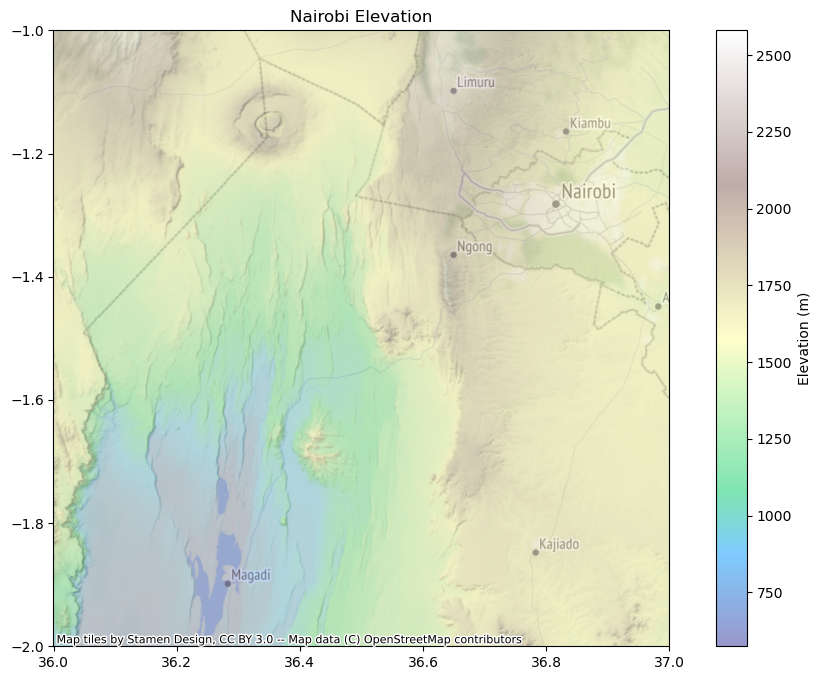

In [32]:
# Create a plot and display the raster data
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(elevation_data, cmap="terrain", alpha=.5, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ctx.add_basemap(ax, crs=src.crs, alpha=.5)
cb = fig.colorbar(im, ax=ax, label='Elevation (m)')
plt.title('Nairobi Elevation')
plt.show()

## Raster Operations

- Raster operations are essential for processing and analyzing raster data. In this section, we will cover several common raster operations, including:
    - **Cropping**
    - **Resampling**
    - **Masking/filtering**.

### Cropping the Elevation Raster Data

- Cropping raster data is a common operation to focus on a specific area of interest. In this example, we will crop the elevation data to the city of Nairobi, Kenya.
- To crop the raster data, we first need to define the area of interest. We can use a polygon that represents the boundary of Nairobi. You can either create this polygon manually or load it from an existing file (e.g., a shapefile or GeoJSON). 

For this example, we will use a manually defined bounding box.

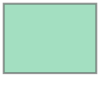

In [33]:
# Create the Nairobi box
xmin, ymin, xmax, ymax = 36.66, -1.37, 37.06, -1.07
nairobi_bbox = box(xmin, ymin, xmax, ymax)
nairobi_bbox

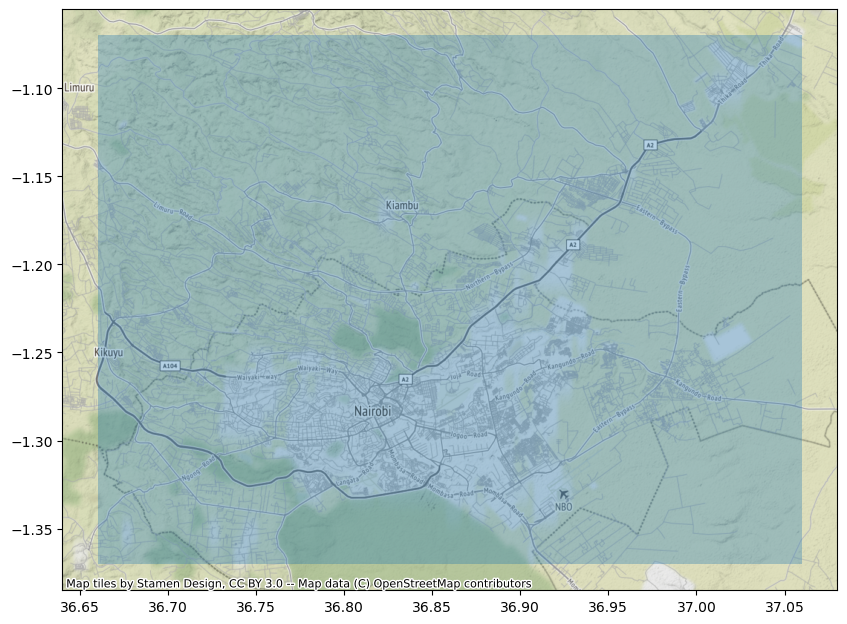

In [34]:
# Load the bounding box as a GeoDataFrame
nairobi_gdf = gpd.GeoDataFrame(geometry=[nairobi_bbox], crs="EPSG:4326")

# Verify that the bounding box covers Nairobi by plotting it:
fig, ax = plt.subplots(figsize=(10, 10))
_ = nairobi_gdf.plot(ax=ax, alpha=.33)
ctx.add_basemap(ax=ax, crs="epsg:4326")
plt.show()

Now, let's load and crop the elevation raster data to focus on Nairobi:

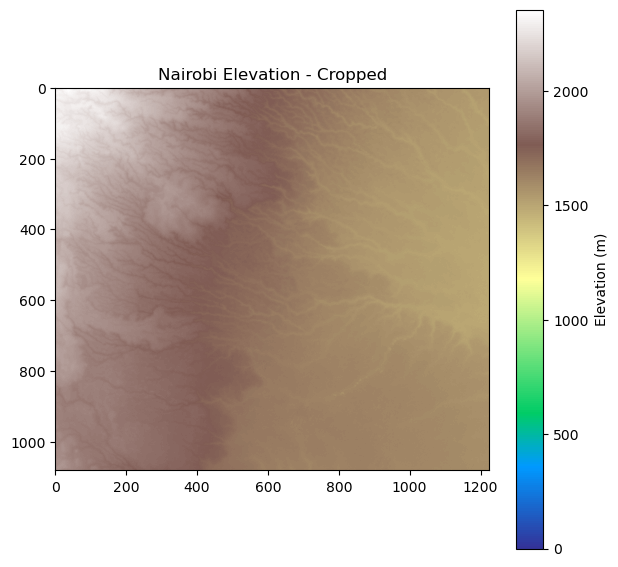

In [35]:
with rio.open(nairobi_elevation_file) as src:
    
    # Crop the raster data to the Nairobi bounding box
    nairobi_elevation_data, nairobi_transform = rio_mask(src, nairobi_gdf.geometry, nodata=0.0, crop=True)

# Plot the cropped raster data
plt.figure(figsize=(7, 7))
plt.imshow(nairobi_elevation_data[0], cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Nairobi Elevation - Cropped')
plt.show()

### Resampling Raster Data

Resampling raster data is often necessary when working with datasets of different resolutions or when reducing the file size. 

In this example, we will resample the original raster to a lower resolution.

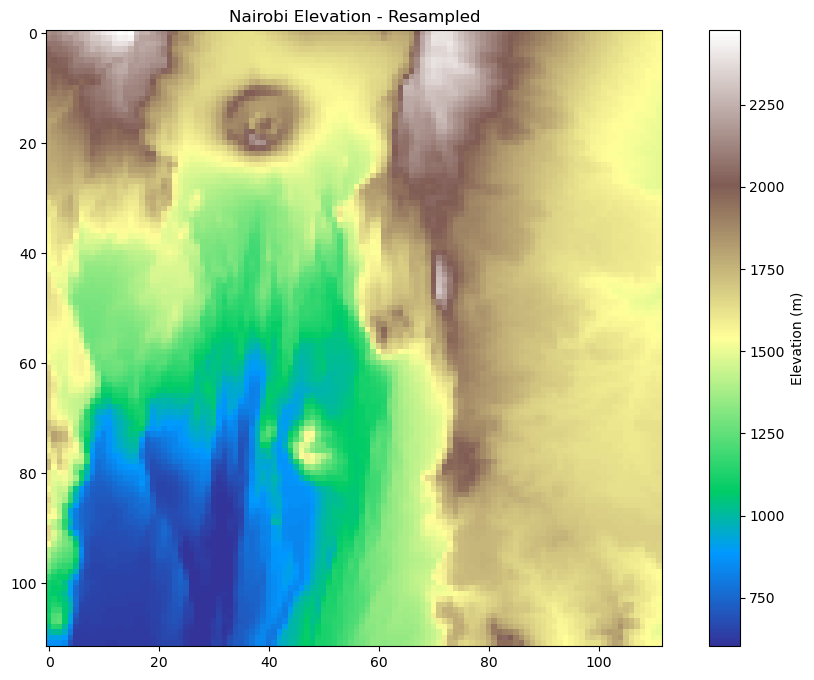

In [36]:
resampling_factor = 32  # Factor by which to reduce the resolution

with rio.open(nairobi_elevation_file) as src:
    
    # Resample the raster data using bilinear interpolation
    resampled_elevation_data = src.read(1, 
                                        out_shape=(src.height // resampling_factor, src.width // resampling_factor),
                                        resampling=Resampling.bilinear)

# Plot the resampled raster data
plt.figure(figsize=(12, 8))
plt.imshow(resampled_elevation_data, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Nairobi Elevation - Resampled')
plt.show()

### Raster Masking and Filtering

- Raster masking and filtering are useful for extracting specific information from raster data. 
- In this example, we will apply a mask to the elevation data to show only the areas above a certain elevation.

In [38]:
elevation_threshold = 1800  # Elevation in meters

with rio.open(nairobi_elevation_file) as src:

    # Crop the raster data to the Nairobi bounding box
    nairobi_elevation_data, nairobi_transform = rio_mask(src, nairobi_gdf.geometry, nodata=0.0, crop=True)

In [42]:
# Convert the elevation data to a float array
nairobi_elevation_data = nairobi_elevation_data.astype(float)

# Apply the mask to the elevation data
masked_elevation_data = nairobi_elevation_data.copy()
masked_elevation_data[masked_elevation_data < elevation_threshold] = np.nan

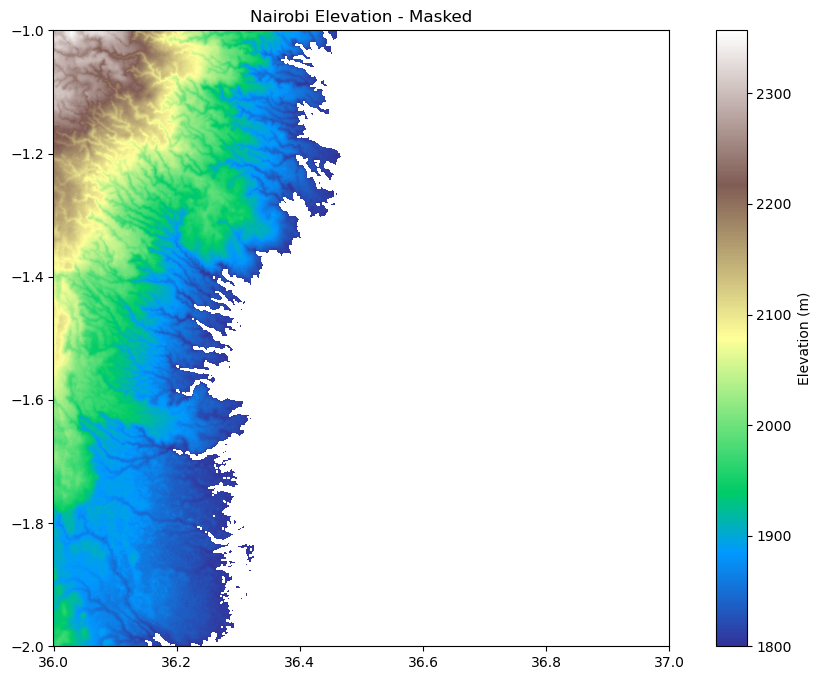

In [43]:
# Plot the masked raster data
plt.figure(figsize=(12, 8))
plt.imshow(masked_elevation_data[0], cmap='terrain', extent=plotting_extent(src, nairobi_transform))
plt.colorbar(label='Elevation (m)')
plt.title('Nairobi Elevation - Masked')
plt.show()

## Raster Data Analysis

In this section, we'll cover the following raster data analysis topics:

- Raster data statistics
- Raster algebra
- Zonal statistics

### Raster Data Statistics

Raster data statistics allow us to analyze the distribution and patterns of the data in a raster dataset. Common statistics include **minimum, maximum, mean, median, and standard deviation**. 

In [45]:
# Compute raster statistics
with rio.open(nairobi_elevation_file) as src:
    elevation_band = src.read(1)
    stats = {
        'min': elevation_band.min(),
        'max': elevation_band.max(),
        'mean': elevation_band.mean(),
        'median': np.median(elevation_band),
        'std_dev': elevation_band.std()
    }

print("Elevation Statistics for Nairobi")
print(stats)

Elevation Statistics for Nairobi
{'min': 574, 'max': 2581, 'mean': 1475.3476824335492, 'median': 1583.0, 'std_dev': 399.5257791172609}


### Raster Algebra

Raster algebra involves performing mathematical operations on raster datasets, such as addition, subtraction, multiplication, and division. 

These operations can be performed between two raster datasets or between a raster dataset and a scalar value. In this example, we will demonstrate how to perform a simple raster algebra operation by adding a constant value to the Nairobi elevation dataset.

In [46]:
# Add 100 meters to the elevation data
adjusted_elevation_data = elevation_band + 100

# Compute and print the new statistics
adjusted_stats = {
    'min': adjusted_elevation_data.min(),
    'max': adjusted_elevation_data.max(),
    'mean': adjusted_elevation_data.mean(),
    'median': np.median(adjusted_elevation_data),
    'std_dev': adjusted_elevation_data.std()
}

print("Adjusted Elevation Statistics for Nairobi")
print(adjusted_stats)

Adjusted Elevation Statistics for Nairobi
{'min': 674, 'max': 2681, 'mean': 1575.3476824335492, 'median': 1683.0, 'std_dev': 399.5257791172609}


### Zonal Statistics

Zonal statistics refer to the computation of statistics for specific zones or regions within a raster dataset. This can be useful for understanding the distribution and patterns of data within specific regions. In this example, we will use the `rasterstats` library to compute zonal statistics for the Nairobi elevation data.

In [47]:
# Compute zonal statistics
zonal_statistics = zonal_stats(nairobi_gdf, nairobi_elevation_file, stats=['min', 'max', 'mean', 'median', 'std'])

# Print zonal statistics
print("Zonal Statistics for Nairobi")
print(zonal_statistics)

Zonal Statistics for Nairobi
[{'min': 1480.0, 'max': 2357.0, 'mean': 1735.4874337184765, 'std': 179.14979122929398, 'median': 1682.0}]


In this section, we covered raster data statistics, raster algebra, and zonal statistics. These techniques allow you to perform various types of analysis on raster datasets.

## Writing Raster Data

In this section, we'll cover the following topics:

- Creating a new raster file.
- Writing raster data to a file.

### Creating a New Raster File

To create a new raster file, we:
1. first need to define the metadata for the file, such as the dimensions, data type, coordinate reference system, and geotransform. 
2. We can then use Rasterio's `rasterio.open()` function in write mode (`'w'`) to create the file.
3. write the data to it.

In [49]:
# Set the target file path
output_filename = './data/raster/out_adjusted_nairobi_elevation.tif'

# Define the metadata for the new raster file
metadata = src.meta.copy()
metadata.update({
    'dtype': adjusted_elevation_data.dtype,
    'count': 1
})

# Create a new raster file and write the adjusted elevation data
with rio.open(output_filename, 'w', **metadata) as dst:
    dst.write(adjusted_elevation_data, 1)

### Writing Raster Data to a File

In the previous example, we wrote the adjusted elevation data to a new raster file. The same process can be used to write any raster data to a file. Just make sure to update the metadata with the appropriate values for your data before writing it to the file.

Here's a generalized example of how to write raster data to a file using Rasterio:

In [50]:
with rio.open(nairobi_elevation_file) as src:

    output_filename = './data/raster/your_output_file.tif'

    # Define the metadata for the new raster file
    metadata = {
        'driver': 'GTiff',
        'width': src.width,
        'height': src.height,
        'count': src.count,
        'dtype': src.dtypes[0],
        'crs': src.crs,
        'transform': src.transform
    }

    # Create a new raster file and write your raster data
    with rio.open(output_filename, 'w', **metadata) as dst:
        for band_index in range(src.count):
            dst.write(src.read(band_index + 1), band_index + 1)

In this section, we covered how to create a new raster file and write raster data to it using `Rasterio`.

## Additional Resources and Further Reading

1. [Rasterio Documentation](https://rasterio.readthedocs.io/en/latest/): The official Rasterio documentation is a comprehensive guide to the library, its functions, and usage examples. It's a great starting point for diving deeper into Rasterio.
2. [Introduction to Raster Data Processing in Open Source Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/)
3. [What is Raster Data](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/).
3. [Automating GIS Processes - Raster Data](https://automating-gis-processes.github.io): This online course by the University of Helsinki covers various topics related to GIS and geospatial analysis using Python, including raster data processing with Rasterio.
4. [Rasterio GitHub Repository](https://github.com/mapbox/rasterio): The GitHub repository for Rasterio contains useful information, example code, and discussions on various issues related to the library.
5. [Awesome Geospatial Python Libraries](https://github.com/sacridini/Awesome-Geospatial): For more general geospatial Python libraries, you can refer to the following list. Many of these libraries have tutorials and resources available to help you learn how to use them effectively.

---